In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[1]))
from model import plot_style, network_model, util

In [3]:
# core parameters
rE_target = 5
rI_target = 10
thetaE = 5.34
thetaI = 82.43

max_duration = 12
dt = 1e-5

In [ ]:
# simulation wrapper function
def bistable_no_depression(stimulus_duration, stimulus_amplitude, 
                           dt, max_duration:int,
                           WEE, WEI, WIE, WII, thetaE, thetaI, tauE=10e-3, tauI=10e-3,
                           initial_conditions=[0, 0]):
    duration = max_duration
    rmax = 100
    total_duration = duration + stimulus_duration + 1 # 1 second of equilibration pre-stimulus
    
    IappI = np.zeros(int(total_duration/dt))
    IappE = np.zeros(int(total_duration/dt))
    IappE[int(1/dt):int((stimulus_duration + 1)/dt)] = stimulus_amplitude
    IappI[int(1/dt):int((stimulus_duration + 1)/dt)] = stimulus_amplitude

    rE, rI = network_model.simulateISP(dt, total_duration, rmax, tauE, tauI, 
                            WEE, WEI, WIE, WII, thetaE, thetaI,
                            IappI, IappE, rE0=initial_conditions[0], rI0=initial_conditions[1])   
    # check stability
    stable = np.allclose(rE[int((max_duration - 0.1)/dt):], rE[-1], atol=0.1, rtol=0)
    
    if not stable: # flag as unstable with negative values
        rE *= -1
        rI *= -1
    return rE, rI    
    
def trial(stim_amp, stim_dur, WEE, WEI, WIE, WII):
    rE, rI = bistable_no_depression(stim_dur, stim_amp, 
                                            dt, max_duration,
                                            WEE, WEI, WIE, WII, thetaE, thetaI)
    # run again
    rE_2, rI_2 = bistable_no_depression(stim_dur, stim_amp, 
                                    dt, max_duration,
                                    WEE, WEI, WIE, WII, thetaE, thetaI, 
                                    initial_conditions=[rE[-1], rI[-1]])
    # stitch together
    rE_full = np.concatenate((rE, rE_2))
    rI_full = np.concatenate((rI, rI_2))
    return rE_full, rI_full

In [69]:
data_dir = '../figure2/data' 

WEE_mesh = np.load(data_dir + '/WEE_mesh.npy', allow_pickle=True)
WEI_mesh = np.load(data_dir + '/WEI_mesh.npy', allow_pickle=True)
WIE_mesh = np.load(data_dir + '/WIE_mesh.npy', allow_pickle=True)
WII_mesh = np.load(data_dir + '/WII_mesh.npy', allow_pickle=True)
n = int(np.sqrt(WEE_mesh.shape[0]))
WEE_mesh = WEE_mesh.reshape((n, n))
WEI_mesh = WEI_mesh.reshape((n, n))
WIE_mesh = WIE_mesh.reshape((n, n))
WII_mesh = WII_mesh.reshape((n, n))

selected_points = [(1, 5), (15, 15),(10, 35)]

In [70]:
raw_areas = np.load(data_dir + '/areas.npy', allow_pickle=True)

stimulus_durations = np.load(data_dir + '/stim_durations.npy', allow_pickle=True)
stimulus_amplitudes = np.load(data_dir + '/stim_amplitudes.npy', allow_pickle=True)
m = len(stimulus_durations)
dur_mesh, amp_mesh = np.meshgrid(stimulus_durations, stimulus_amplitudes)

In [71]:
raw_areas = raw_areas.reshape(n, n, m, m)

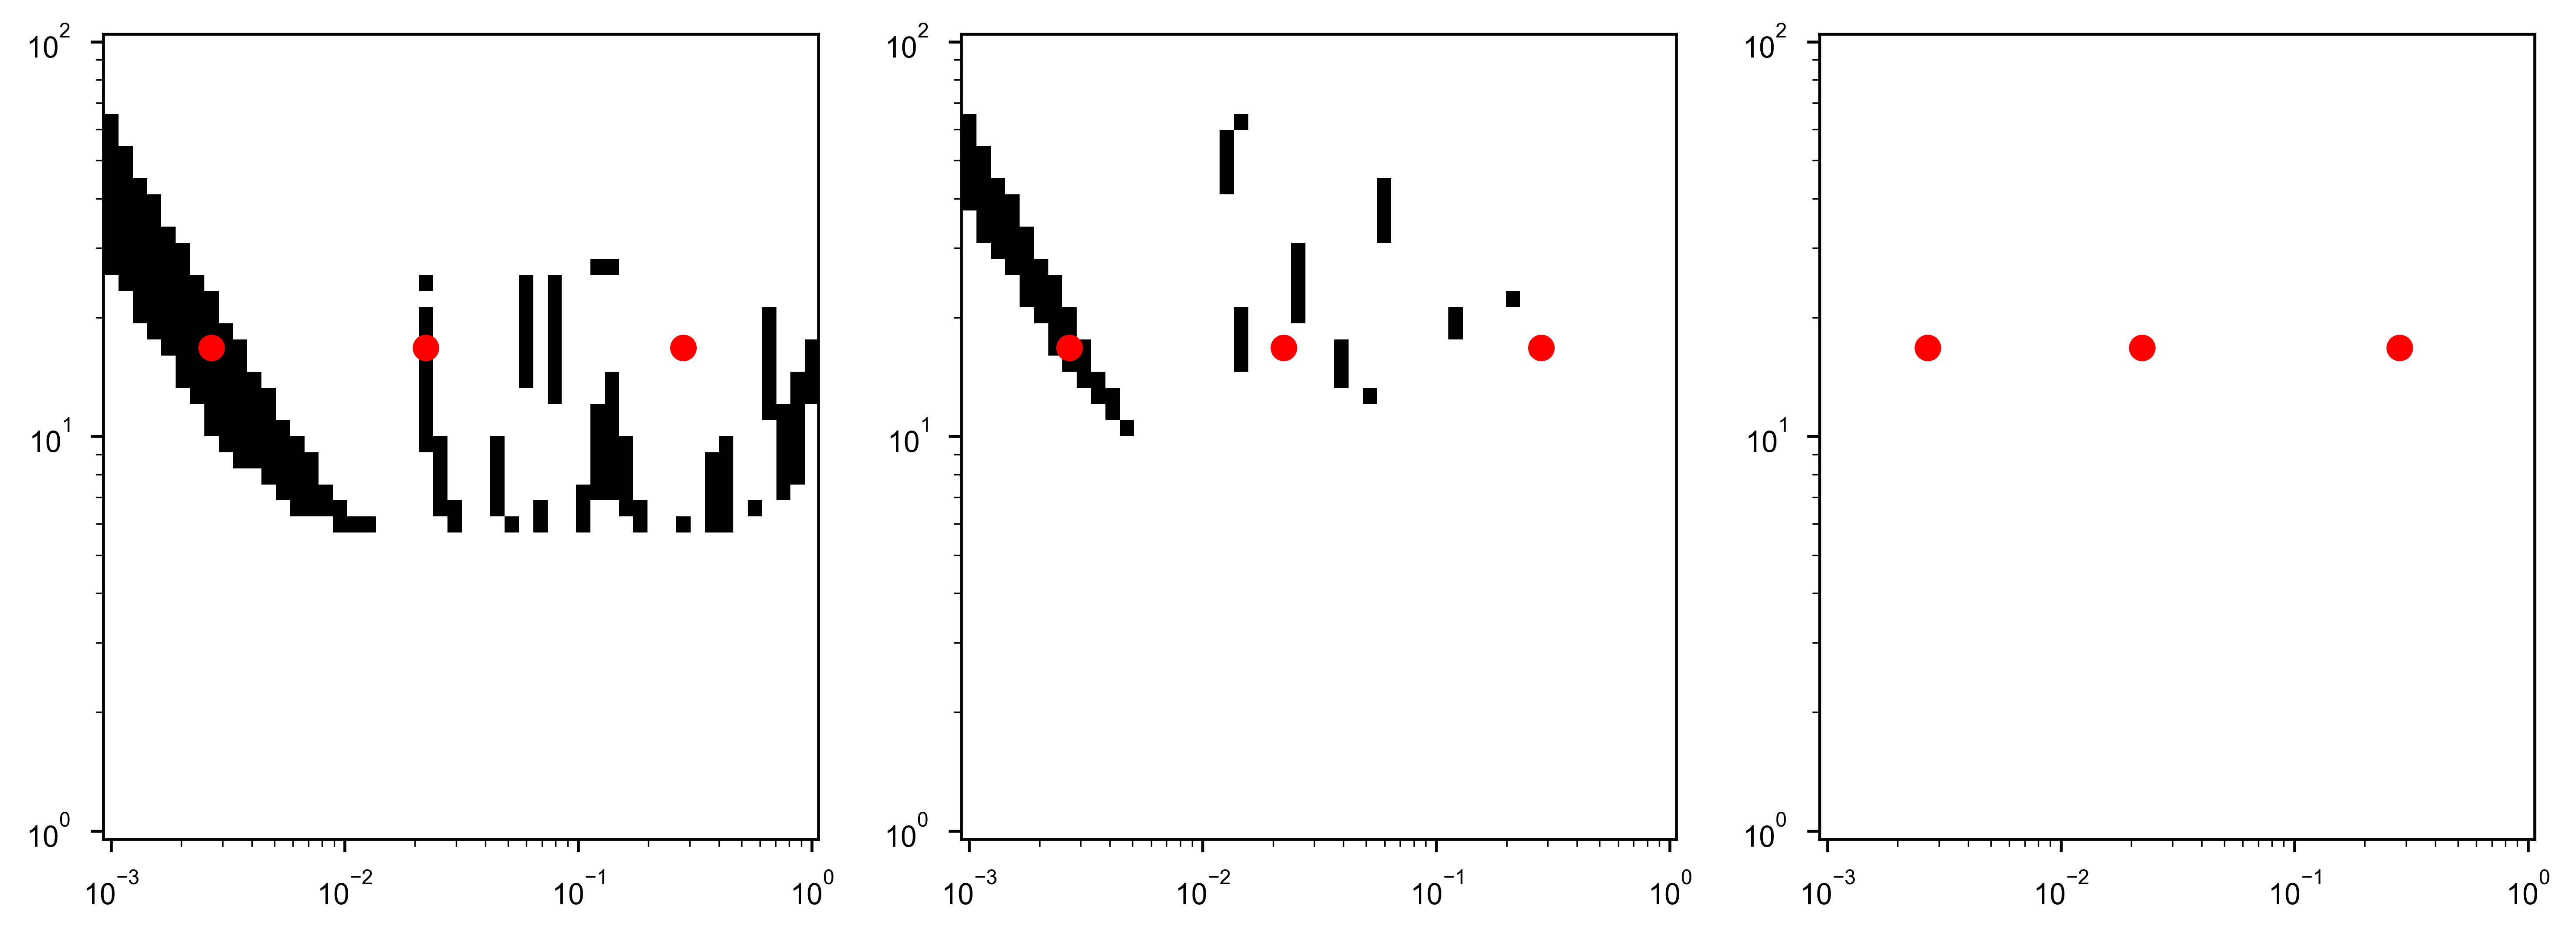

In [76]:
# plot selected points
selected_stimuli = [(30, 7), (30, 22), (30, 40)]
selected_durs = [dur_mesh[s] for s in selected_stimuli]
selected_amps = [amp_mesh[s] for s in selected_stimuli]

fig, axes = plt.subplots(1, len(selected_points), figsize=(12, 4))
sample_dict = {'A':{}, 'B':{}, 'C':{}}
for idx, (i, j) in enumerate(selected_points):
    WEE = WEE_mesh[i, j]
    WEI = WEI_mesh[i, j]
    WIE = WIE_mesh[i, j]
    WII = WII_mesh[i, j]
    key = chr(ord('A') + idx)
    sample_dict[key]['WEE'] = WEE
    sample_dict[key]['WEI'] = WEI
    sample_dict[key]['WIE'] = WIE
    sample_dict[key]['WII'] = WII
    
    areas = raw_areas[i][j]
    sample_dict[key]['areas'] = areas
    
    ax = axes[idx]
    ax.pcolormesh(dur_mesh, amp_mesh, areas, shading='auto', cmap='binary')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.scatter(selected_durs, selected_amps, color='red', s=50, label='Sample Stimuli')

In [77]:
traces = []
for key in sample_dict:
    WEE = sample_dict[key]['WEE']
    WEI = sample_dict[key]['WEI']
    WIE = sample_dict[key]['WIE']
    WII = sample_dict[key]['WII']
    areas = sample_dict[key]['areas']
    
    trace_set = []
    for stim_dur, stim_amp in zip(selected_durs, selected_amps):
        rE, rI = trial(stim_amp, stim_dur, WEE, WEI, WIE, WII)
        trace_set.append((rE, rI))
    traces.append(trace_set)

In [63]:
from matplotlib.patches import Patch


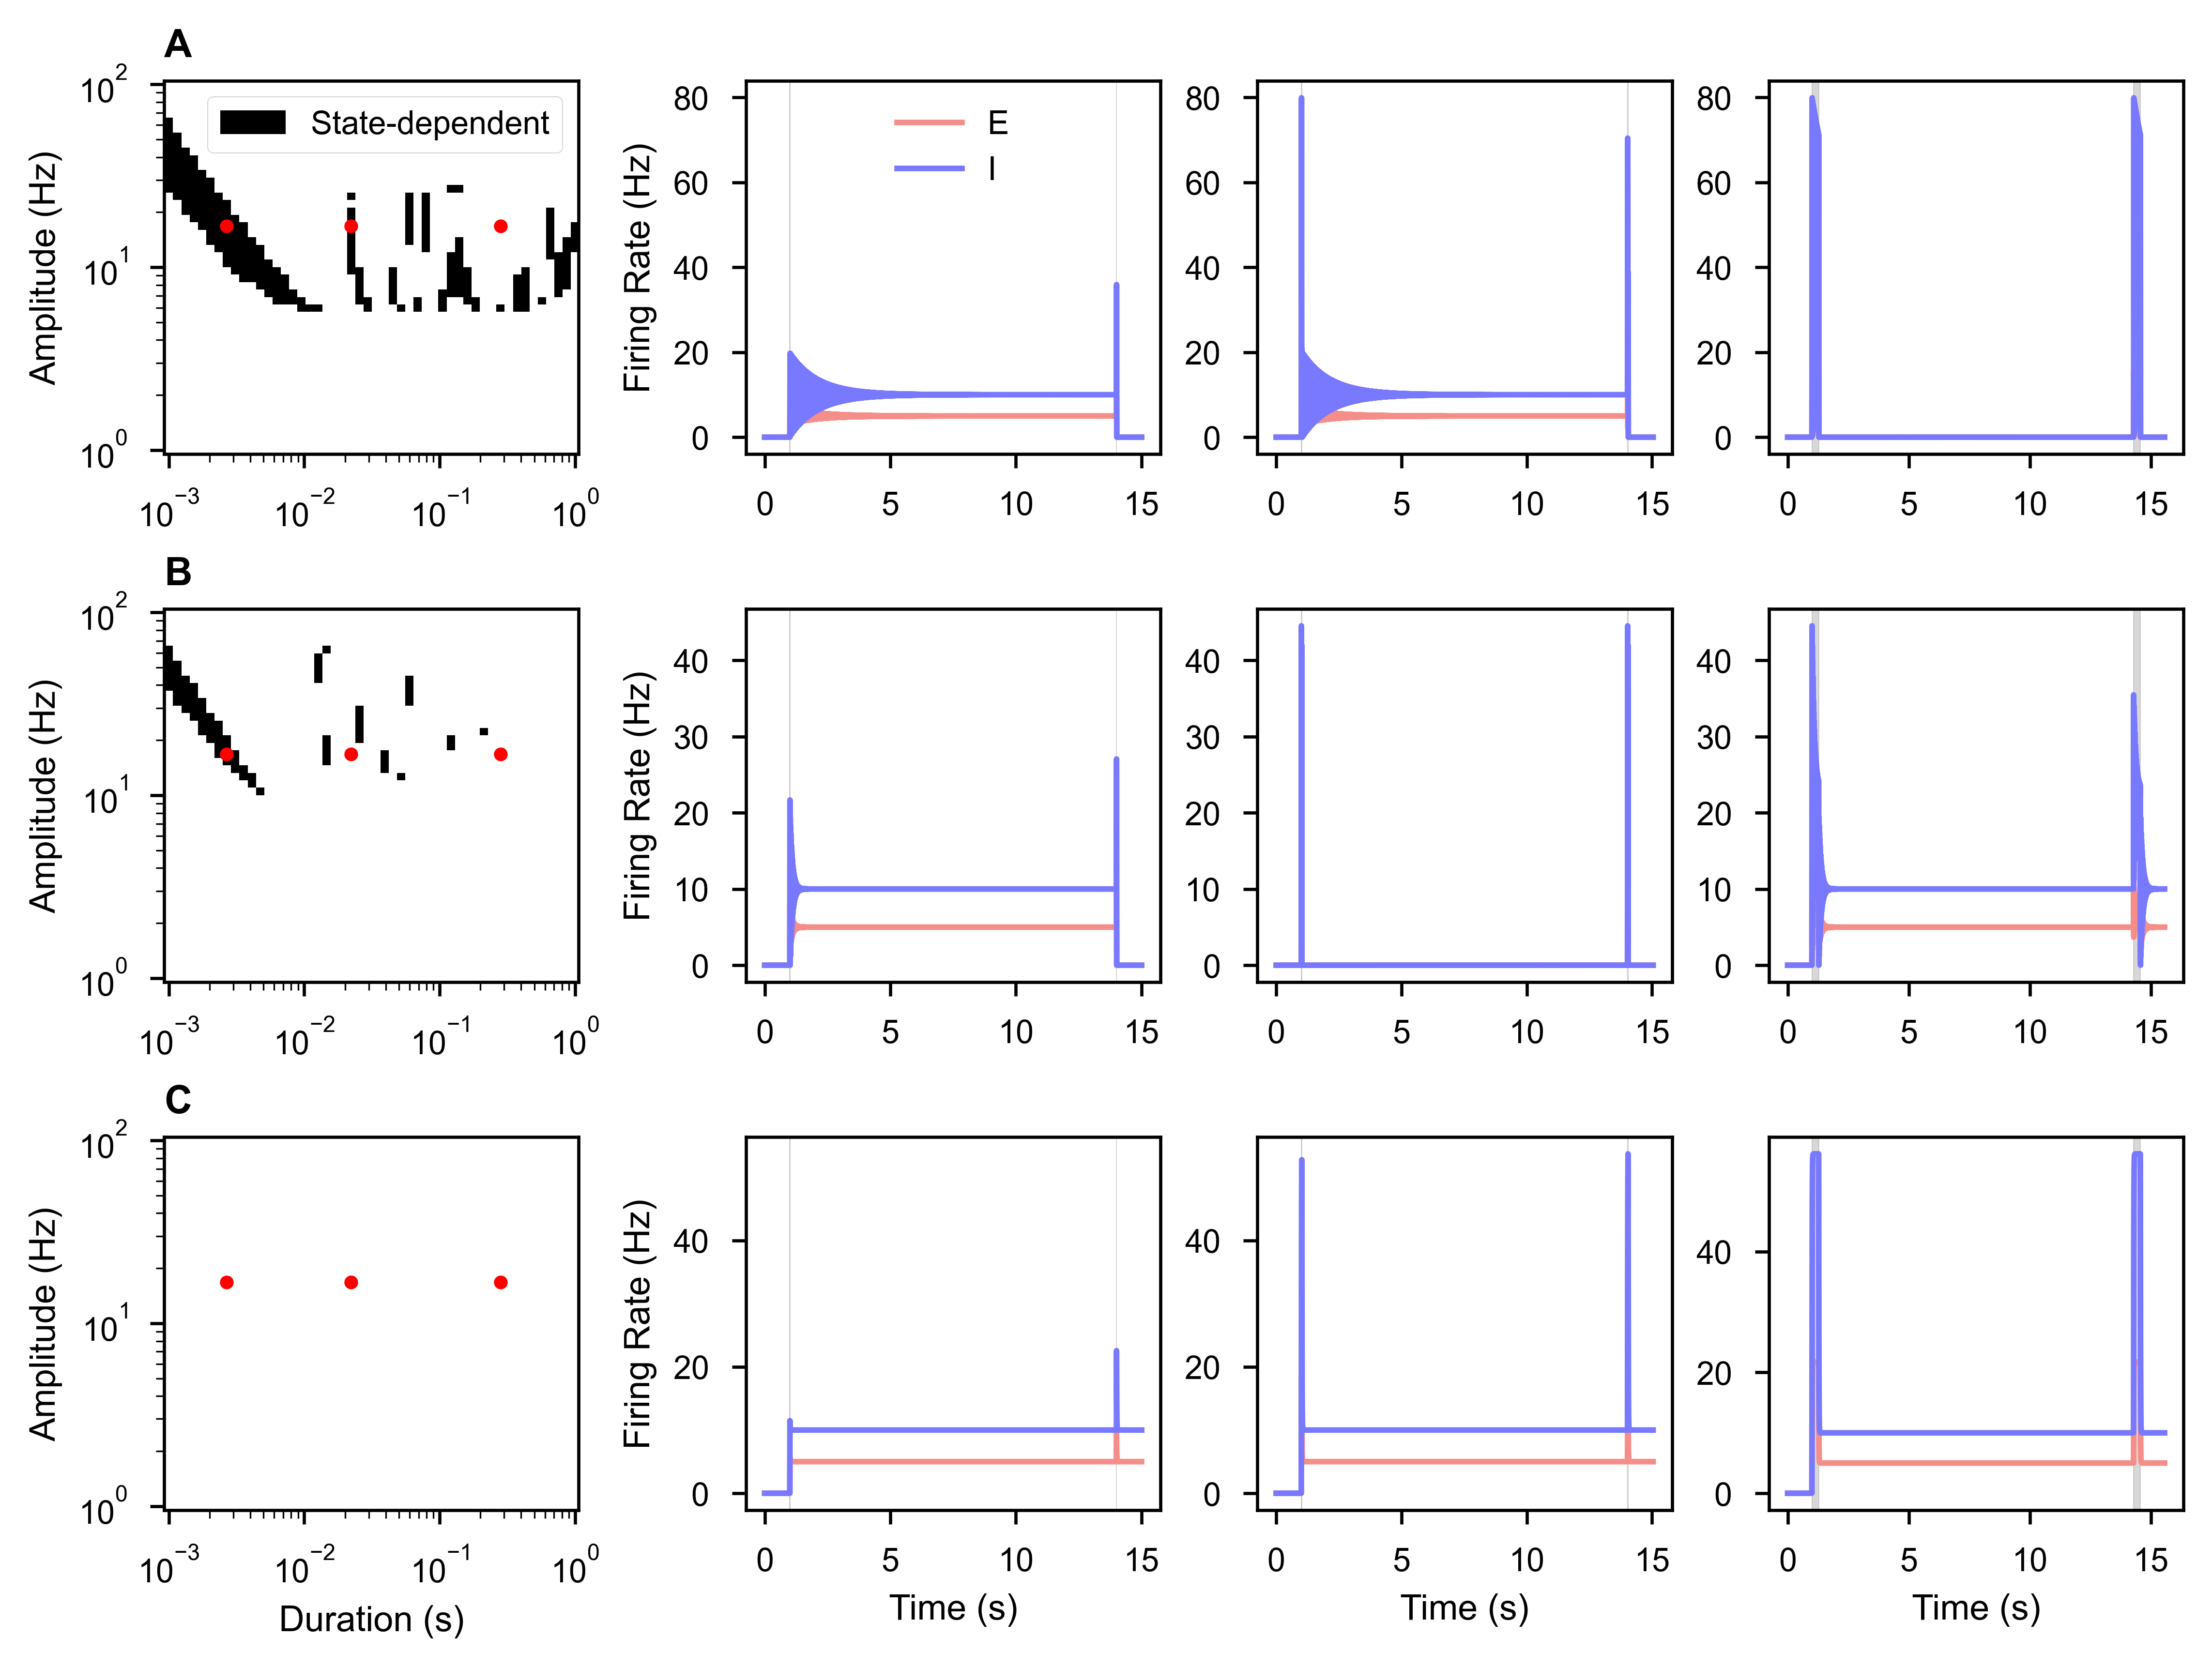

In [ ]:
px = 1/plt.rcParams['figure.dpi']   # convert pixel to inches
fig = plt.figure(layout='constrained', figsize=(plot_style.MAX_WIDTH*px, plot_style.MAX_WIDTH*px*0.75))
axd = fig.subplot_mosaic(
    """
    Abcd
    Befg
    Chij
    """
)
axd['A'].sharex(axd['B'])
axd['A'].sharey(axd['C'])
# handle grid of shared axes
for ax_key in ('b', 'e', 'h'):
    axd[ax_key].sharey(axd[chr(ord(ax_key)+1)])
    # axd[ax_key].sharey(axd[chr(ord(ax_key)+2)])
    axd[ax_key].set_ylabel('Firing Rate (Hz)')
for ax_key in ('h', 'i', 'j'):
    axd[ax_key].sharex(axd[chr(ord(ax_key)-3)])
    axd[ax_key].set_xlabel('Time (s)')
for name, ax in axd.items():
    if name in ('A', 'B', 'C'):
        ax.set_title(name, loc='left', fontweight='bold')
        if name=='C': ax.set_xlabel('Duration (s)')
        ax.set_ylabel('Amplitude (Hz)')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.pcolormesh(dur_mesh, amp_mesh, sample_dict[name]['areas'], shading='auto', cmap='binary')
        ax.scatter(selected_durs, selected_amps, color='red', s=10, label='Sample Stimuli')
        if name == 'A':
            legend_elements = [Patch(facecolor='black', edgecolor='black', label='State-dependent')]
            ax.legend(handles=legend_elements, loc='upper right')
for i, row in enumerate([['b', 'c', 'd'], ['e', 'f', 'g'], ['h', 'i', 'j']]):
    for j, ax_key in enumerate(row):
        ax = axd[ax_key]
        rE, rI = traces[i][j]
        # truncate
        stim_dur = selected_durs[j]
        stim_amp = selected_amps[j]
        max_idx= int((max_duration + 2*(stim_dur + 1) + 1)/dt)
        rE = rE[:max_idx]
        rI = rI[:max_idx]
        time = np.arange(0, 2*(max_duration + stim_dur + 1) + 1, dt)[:len(rE)] # truncate for safety
        ax.plot(time, rE, label='E', color=plot_style.excit_red)
        ax.plot(time, rI, label='I', color=plot_style.inh_blue)
        ax.axvspan(1, stim_dur + 1, color='gray', alpha=0.3)
        ax.axvspan(max_duration + stim_dur + 2, max_duration + 2*(stim_dur + 1), color='gray', alpha=0.3)
        if i == 0 and j == 0:
            ax.legend(frameon=False)

In [81]:
fig.savefig('flip_flop_samples.png', dpi=300)
fig.savefig('flip_flop_samples.tiff', dpi=300)